In [23]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


### Create a StateGraph

In [ ]:
class State(TypedDict):
    # Messages have the type list. The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

###  Add a node

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()  # load environment variables from .env

# --- Environment Variable Checks ---
google_api_key_loaded = os.getenv(GOOGLE_API_KEY) is not None

print(fGoogle API Key Loaded: {google_api_key_loaded})

Google API Key Loaded: True


In [ ]:
from langchain.chat_models import init_chat_model
llm = init_chat_model(gemini-2.0-flash, 
                        model_provider=google_genai,
                        temperature=0)
# model = init_chat_model(gemini-1.5-flash, model_provider=google_genai)

response = llm.invoke(Hello, world!)
print(response)

content='Hello there! How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--d26af9da-4197-4531-80a8-aadf93850e58-0' usage_metadata={'input_tokens': 4, 'output_tokens': 11, 'total_tokens': 15, 'input_token_details': {'cache_read': 0}}


In [ ]:
def chatbot(state: State):
    return {messages: [llm.invoke(state[messages])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node(chatbot, chatbot)

In [ ]:
graph_builder.add_edge(START, chatbot)

In [7]:
graph = graph_builder.compile()

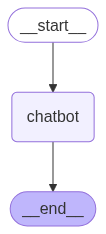

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({messages: [{role: user, content: user_input}]}):
        for value in event.values():
            print(Assistant:, value[messages][-1].content)


while True:
    try:
        user_input = input(User: )
        if user_input.lower() in [quit, exit, q]:
            print(Goodbye!)
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = What do you know about LangGraph?
        print(User:  + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I help you today?
Assistant: LLM Framework
Goodbye!


### Tool calling

In [31]:
restaurants_data = {
        "Pizza": ["Dominos", "Pizza Hut", "Luigi's Pizzeria"],
        "Burger": ["McDonald's", "Burger King", "Shake Shack"],
        "Sushi": ["obu", "Sushi Samba", "Kura Sushi"],
        "Pasta": ["Olive Garden", "Carrabba's", "Maggiano's"],
        "Salad": ["Sweetgreen", "Chopt", "Saladworks"],
        "Ice Cream": ["Baskin Robbins", "Ben & Jerry's", "Cold Stone Creamery"]
}

print(restaurants_data["Pizza"])

['Dominos', 'Pizza Hut', "Luigi's Pizzeria"]


In [32]:
from langchain_core.tools import tool

@tool
def restaurant_search_tool(dish_name: str) -> str:
    """Searches for restaurants serving the given dish and returns a list of restaurants or a message if not found."""
    print(f"--- Tool: restaurant_search_tool called with dish: {dish_name} ---")
    # Simple case-insensitive search for the dish key
    found_restaurants = []
    for key_dish, restaurants_list in restaurants_data.items():
        if dish_name.lower() in key_dish.lower():
            found_restaurants.extend(restaurants_list)
    
    if found_restaurants:
        # Remove duplicates if a dish name matches multiple keys (e.g. if data had 'Pizza' and 'Gourmet Pizza')
        unique_restaurants = sorted(list(set(found_restaurants)))
        return f"The dish '{dish_name}' is available at: {', '.join(unique_restaurants)}."
    else:
        return f"Sorry, I couldn't find any restaurants serving '{dish_name}'."

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 2. Bind the tool to the LLM
# Ensure 'llm' is defined from the previous cell
llm_with_tools = llm.bind_tools([restaurant_search_tool])

In [34]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [ ]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools=[restaurant_search_tool])

In [36]:
graph_builder.add_node("tools", tool_node)

In [37]:
from langgraph.graph import StateGraph, START, END


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

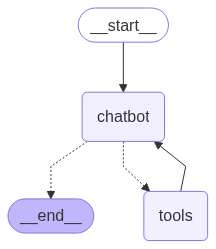

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [39]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User:", user_input)
        
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: Hello! How can I help you today?
User: I want to eat pizza
Assistant: 
--- Tool: restaurant_search_tool called with dish: pizza ---
Assistant: The dish 'pizza' is available at: Dominos, Luigi's Pizzeria, Pizza Hut.
Assistant: OK. I see that pizza is available at Dominos, Luigi's Pizzeria, and Pizza Hut.
User: q
Goodbye!


### Using 2 Tools

In [53]:
restaurants_data = {
        "Pizza": ["Dominos", "Pizza Hut", "Luigi's Pizzeria"],
        "Burger": ["McDonald's", "Burger King", "Shake Shack"],
        "Sushi": ["obu", "Sushi Samba", "Kura Sushi"],
        "Pasta": ["Olive Garden", "Carrabba's", "Maggiano's"],
        "Salad": ["Sweetgreen", "Chopt", "Saladworks"],
        "Ice Cream": ["Baskin Robbins", "Ben & Jerry's", "Cold Stone Creamery"]
}

print(restaurants_data["Pizza"])

['Dominos', 'Pizza Hut', "Luigi's Pizzeria"]


In [54]:
from langchain_core.tools import tool

@tool
def restaurant_search_tool(dish_name: str) -> str:
    """Searches for restaurants serving the given dish and returns a list of restaurants or a message if not found."""
    print(f"--- Tool: restaurant_search_tool called with dish: {dish_name} ---")
    # Simple case-insensitive search for the dish key
    found_restaurants = []
    for key_dish, restaurants_list in restaurants_data.items():
        if dish_name.lower() in key_dish.lower():
            found_restaurants.extend(restaurants_list)
    
    if found_restaurants:
        # Remove duplicates if a dish name matches multiple keys (e.g. if data had 'Pizza' and 'Gourmet Pizza')
        unique_restaurants = sorted(list(set(found_restaurants)))
        return f"The dish '{dish_name}' is available at: {', '.join(unique_restaurants)}."
    else:
        return f"Sorry, I couldn't find any restaurants serving '{dish_name}'."

In [55]:
import requests

@tool
def get_order_details_from_api(restaurant_name: str, dish_name: str) -> dict:
    """
    Calls the restaurant order API and returns the order details.

    Args:
        restaurant_name: The name of the restaurant.
        dish_name: The name of the dish ordered.

    Returns:
        A dictionary containing the order details, or None if an error occurs.
    """
    print(f"--- Tool: get_order_details_from_api called with restaurant_name: {restaurant_name} and dish_name: {dish_name}---")
    url = f"http://127.0.0.1:8000/orders/{restaurant_name}"
    params = {"dish_name": dish_name}

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error calling the API: {e}")
        if response.status_code == 404:
            print(f"Restaurant or dish not found: {response.json().get('detail', 'Unknown error')}")
        return None

In [56]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 2. Bind the tool to the LLM
# Ensure 'llm' is defined from the previous cell
llm_with_tools = llm.bind_tools([restaurant_search_tool,get_order_details_from_api])

In [57]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [58]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools=[restaurant_search_tool,get_order_details_from_api])

In [59]:
graph_builder.add_node("tools", tool_node)

In [60]:
from langgraph.graph import StateGraph, START, END


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

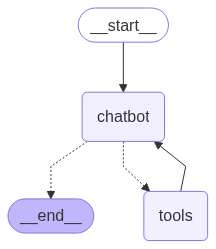

In [61]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [63]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User:", user_input)
        
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: Hello! How can I help you today?
User: I want to eat pizza
Assistant: 
--- Tool: restaurant_search_tool called with dish: pizza ---
Assistant: The dish 'pizza' is available at: Dominos, Luigi's Pizzeria, Pizza Hut.
Assistant: OK. pizza is available at Dominos, Luigi's Pizzeria, and Pizza Hut. Which restaurant would you like to order from?
User: I want to order pizza from Dominos
Assistant: 
--- Tool: get_order_details_from_api called with restaurant_name: Dominos and dish_name: pizza---
Assistant: {"order_id": "e2e0c6ad-c36a-49a0-b17c-274747efea40", "restaurant_name": "Dominos", "items": ["pizza"], "total_amount": 5.08, "currency": "USD", "ordered_at": "2025-05-14T18:41:43.565516", "estimated_arrival_time": "2025-05-14T19:21:43.565516", "payment_mode": "Debit Card", "status": "Order Placed", "delivery_address": "123 Main St, Anytown, USA", "customer_notes": "Call upon arrival."}
Assistant: OK. I have placed an order for pizza from Dominos. The order details are: 